In this notebook we consider the estimation of the distribution of the confusion matrix

In [127]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from mmur.simulators import LAlgorithm
from mmur.generators import BlobGenerator

Assumed is a Gaussian distribution for both classes. Dataset consists of two Gaussian blobs, with tunable covariance between the features

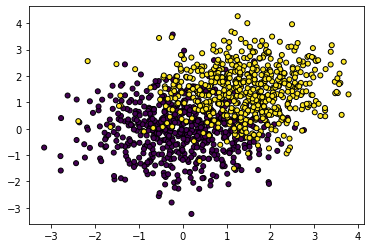

In [129]:
generator = BlobGenerator(
    train_size=1000,
    test_size=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    weights=[0.5, 0.5],
    flip_y=0,
    class_d=2.0,
    scale=1.0,
    shuffle=False,
    random_state=123,
    var=1,
    cov=0,
    random_imbalance=False)
X, y = generator.make_classification()

generator.plot_blobs(X, y, scatter=True, contour=False)


First, we simulate the true confusion matrix distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size.
This is the same as the true distribution of the holdout estimator. From this we can also derive the true distributions of the performance metrics.

Several components are added to resemble noise present in a practical setting. 

<b>random_imbalance</b>: given the class balance set by weights, the number observations with a certain label is sampled from a binomial distribution (multinomial for n_classes>2). Optional is to set a beta prior to this binomial distribution to increase the variance of the draws.

<b>flip_y</b>: fraction of observations that is susceptible to being flipped. If an observation is susceptible it takes any of the labels with equal probability

<b>fix_init</b>: fixes the seed for the learning algorithm

In [174]:
def sim_precisions(train_size, test_size, weights=[0.8,0.2], model_name='LR', class_d=2.0, random_imbalance=False, flip_y=0, nd_train=False, imbalance_prior_a=None, imbalance_prior_b=None, n_runs=5000, n_jobs=-2, random_state=123):

    data_generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        class_d=class_d,
        random_imbalance=random_imbalance,
        imbalance_prior_a=imbalance_prior_a,
        imbalance_prior_b=imbalance_prior_b,
        random_state=random_state,
    )

    LA = LAlgorithm(
        model_name,
        data_generator,
        nd_train=nd_train,
        random_state=data_generator.generator
    )

    cms = LA.sim_true_cms(n_runs, n_jobs=n_jobs)
    precs = LA._cms_to_precision(cms)
    return precs


def sim_CMs(train_size, test_size, weights=[0.8, 0.2], model_name='LR', class_d=2.0, random_imbalance=False, flip_y=0, nd_train=False, imbalance_prior_a=None, imbalance_prior_b=None, n_runs=5000, n_jobs=-2, random_state=123):

    data_generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        class_d=class_d,
        random_imbalance=random_imbalance,
        imbalance_prior_a=imbalance_prior_a,
        imbalance_prior_b=imbalance_prior_b,
        random_state=random_state,
    )

    LA = LAlgorithm(
        model_name,
        data_generator,
        nd_train=nd_train,
        random_state=data_generator.generator
    )

    cms = LA.sim_true_cms(n_runs, n_jobs=n_jobs)
    return cms

def create_and_plot(train_size, test_size, weights, flip_y, random_imbalance, imbalance_prior_a=None, imbalance_prior_b=None, contour=True, scatter=True):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        imbalance_prior_a=imbalance_prior_a,
        imbalance_prior_b=imbalance_prior_b,
        random_state=gen_seed,
    )
    X, y = generator.make_classification()
    generator.plot_blobs(X, y, contour=contour, scatter=scatter)


#### 1. Looking at the effect of sampling noise for the train and test set separately

In [176]:
# First consider the scenario with the least amount of uncertainty. Consider a very large train and test set

params = {
    'train_size':[int(1e6),5000,500],
    'test_size':[int(1e6),1000,100],
    'n_runs' : [5000]
}

# Cartesian product to obtain all parameter combinations
combis = list(it.product(*params.values()))
combis[0] = (int(1e6), int(1e6), 100) # Smaller n_runs value for huge train and test

results = {}
keys = list(params)
for values in combis:
    result_key = ','.join(['='.join([p, str(v)]) for p, v in zip(list(params)[:2], values[:2])])
    results[result_key] = sim_CMs(**dict(zip(params, values)))

with open('exp1_sampling_noise_cm.pkl', 'wb') as f:
    pkl.dump(results, f)


In [ ]:
precs0 = sim_precisions(
    train_size=int(1e6),
    test_size=int(1e6),
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=100)


In [9]:
print("Mean precision of: ", np.round(np.mean(precs0), decimals=3))
print("Std of: ", np.round(np.std(precs0), decimals=3))

# We observe that the precision converges to 0.774 for large train and test sets


Mean precision of:  0.774
Std of:  0.001


In [30]:
# Large train set -- looking at variance solely due to medium test set sample

precs1 = sim_precisions(
    train_size=int(1e6),
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000)

In [31]:
# Large train set -- looking at variance solely due to small test set sample

precs1_1 = sim_precisions(
    train_size=int(1e6),
    test_size=100,
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000)

In [32]:
# Large test set -- looking at variance solely due to medium train set sample

precs2 = sim_precisions(
    train_size=5000,
    test_size=int(1e6),
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000)

In [33]:
# Large test set -- looking at variance solely due to small train set sample

precs2_1 = sim_precisions(
    train_size=500,
    test_size=int(1e6),
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000)

In [34]:
# medium train and test sets -- combined uncertainty

precs3 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000)

In [35]:
# Small train and test sets -- combined uncertainty

precs3_1 = sim_precisions(
    train_size=500,
    test_size=100,
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000)

<AxesSubplot:>

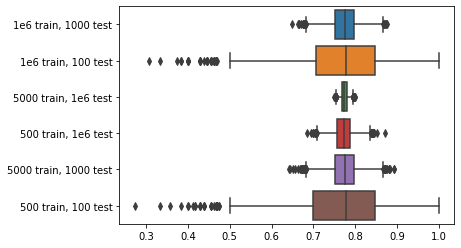

In [41]:
df = pd.DataFrame({'1e6 train, 1000 test': precs1, '1e6 train, 100 test': precs1_1, '5000 train, 1e6 test': precs2, '500 train, 1e6 test': precs2_1,
                   '5000 train, 1000 test': precs3, '500 train, 100 test': precs3_1})

sns.boxplot(data=df, orient='h')

# The test set appears to contribute to the variance most (for logistic regression). Interestingly, a limited size of the train set does not
# seem to contribute much to the variance of the precision.

#### 2. Simulate precision distribution with sampling noise and stochastic class balance

In [43]:
# Function to simulate the observed balances
# The class balance is determined by the sample size, mean balance defined by weights,
# and another weighing term "imbalance_prior_frac" to inflate/deflate variance.

def sim_random_balance(generator, imbalance_prior_a, imbalance_prior_b, n_runs=100):
    generator.imbalance_prior_a = imbalance_prior_a
    generator.imbalance_prior_b = imbalance_prior_b
    bal = []
    for _ in range(n_runs):
        _, y = generator.make_classification()
        bal.append(np.mean(y))
    return bal

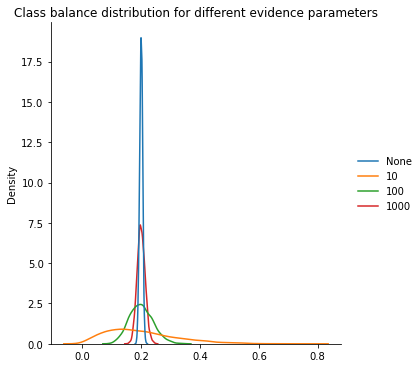

In [51]:
# Simulating the class balance distribution

generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8,0.2],
    random_imbalance=True,
    )

evidence = [None,10,100,1000]

balance_distr = {}
for e in evidence:
    if e is None:
        a, b = None, None
    else:
        a, b = int(e*0.8), int(e*0.2)
    balance_distr[str(e)] = sim_random_balance(
        generator, a, b, n_runs=5000)
sns.displot(pd.DataFrame(balance_distr), kind='kde',
            common_norm=True).set(title='Class balance distribution for different evidence parameters')

Here we compute the distribution of the precision for several degrees of uncertainty in the class balance

In [48]:
# No prior on the class balance
precs4 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    random_imbalance=True,
    n_runs=5000)

# 1,000 evidence
precs4_1 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    random_imbalance=True,
    n_runs=5000,
    imbalance_prior_a=800,
    imbalance_prior_b=200
)

# 100 evidence
precs4_2 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    random_imbalance=True,
    n_runs=5000,
    imbalance_prior_a=80,
    imbalance_prior_b=20
)

# 10 evidence
precs4_3 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    random_imbalance=True,
    n_runs=5000,
    imbalance_prior_a=8,
    imbalance_prior_b=2
)

c:\users\coenv\documents\internship\ing\thesis\code\modelmetricuncertaintyresearch\mmur\simulators\lalgorithm.py:110: RuntimeWarning: invalid value encountered in true_divide
  return TP/(TP+FP)


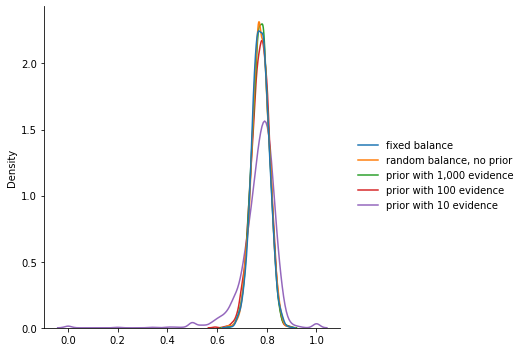

In [54]:
# df = pd.DataFrame({'no random balance' : precs3, 'with random balance' : precs4})
df = pd.DataFrame({'fixed balance': precs3, 'random balance, no prior': precs4, 'prior with 1,000 evidence': precs4_1, 'prior with 100 evidence': precs4_2,
                   'prior with 10 evidence': precs4_3})
sns.displot(df, kind='kde')

# does not appear to make a difference for train_size=5000, perhaps for lower sample sizes? (fixed test size)


<AxesSubplot:>

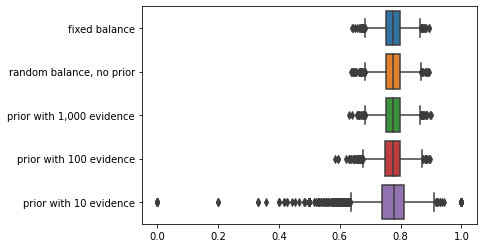

In [55]:
sns.boxplot(data=df, orient='h')

What happens to the effect of random class balance if we increase the complexity of class separation by decreasing the distance between the blob centers?

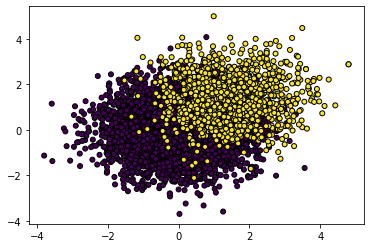

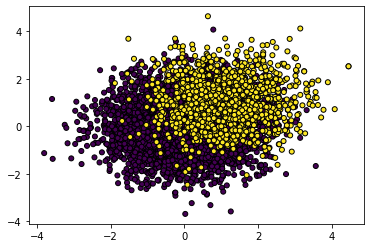

In [60]:
generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    class_d=2,
    random_state=123
)
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)

generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    class_d=1.5,
    random_state=123
)
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)


In [61]:
# no random imbalance
precs4a = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    class_d = 1.5,
    model_name='LR',
    n_runs=5000)

# random imbalance with 100 evidence - prior
precs4a_1 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    class_d = 1.5,
    model_name='LR',
    random_imbalance=True,
    n_runs=5000,
    imbalance_prior_a=80,
    imbalance_prior_b=20
)

<AxesSubplot:>

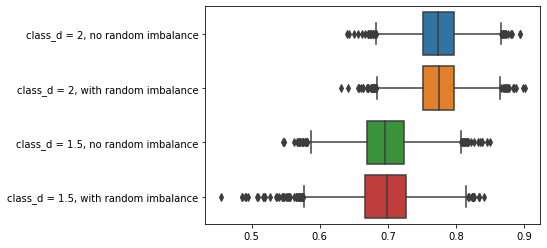

In [69]:
df = pd.DataFrame({'class_d = 2, no random imbalance': precs3, 'class_d = 2, with random imbalance': precs4_1,
                  'class_d = 1.5, no random imbalance': precs4a, 'class_d = 1.5, with random imbalance': precs4a_1})
sns.boxplot(data=df, orient='h')

What is the effect of random balance for a smaller sample size?

In [71]:
precs4b = sim_precisions(
    train_size=500,
    test_size=100,
    weights=[0.8, 0.2],
    model_name='LR',
    n_runs=5000,
    )

precs4b_1 = sim_precisions(
    train_size=500,
    test_size=100,
    weights=[0.8, 0.2],
    model_name='LR',
    random_imbalance=True,
    n_runs=5000,
    imbalance_prior_a=80,
    imbalance_prior_b=20
    )

<AxesSubplot:>

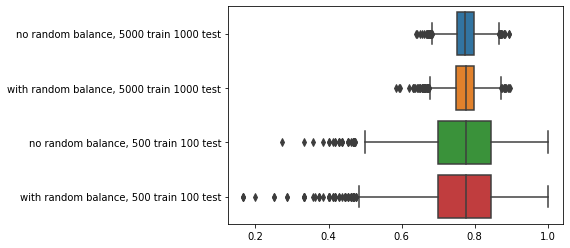

In [75]:
n_precs = np.min([len(precs3), len(precs4_2), len(precs4b), len(precs4b_1)])

df = pd.DataFrame({'no random balance, 5000 train 1000 test': precs3[:n_precs], 'with random balance, 5000 train 1000 test': precs4_2[:n_precs],
                   'no random balance, 500 train 100 test': precs4b[:n_precs], 'with random balance, 500 train 100 test': precs4b_1})

sns.boxplot(data=df, orient='h')


#### 3. Introducing label noise to the data. What is the effect on the distribution of the precision?

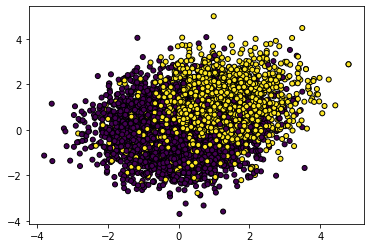

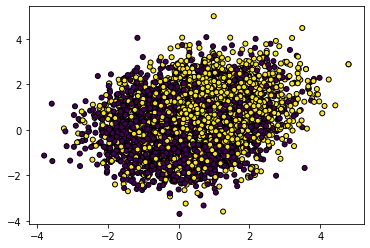

In [80]:
generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8,0.2],
    flip_y=0.1,
    random_state=123,
    )
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)

generator = BlobGenerator(
    train_size=5000,
    test_size=1000,
    weights=[0.8,0.2],
    flip_y=0.3,
    class_d=2.0,
    random_state=123,
    random_imbalance=False)
X, y = generator.make_classification()
generator.plot_blobs(X, y, scatter=True, contour=False)


In [81]:
precs5 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    flip_y=0.1,
    model_name='LR',
    n_runs=5000)

precs5_1 = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    flip_y=0.3,
    model_name='LR',
    n_runs=5000)


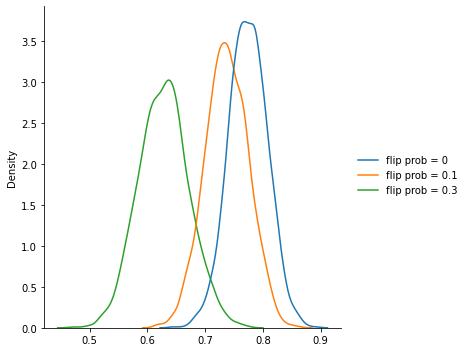

In [85]:
n_precs = np.min([len(precs3), len(precs5), len(precs5_1)])
df = pd.DataFrame(
    {'flip prob = 0': precs3[:n_precs], 'flip prob = 0.1': precs5[:n_precs], 'flip prob = 0.3': precs5_1[:n_precs]})
sns.displot(df, kind='kde')

# The mean precision decreases with higher flip probability.


In [88]:
from scipy.stats import levene
df = pd.DataFrame([['0', '0.1', '0.3'], [np.round(np.std(x), decimals=3)
                  for x in [precs3, precs5, precs5_1]]]).T
df.columns = ['Flip probability', 'std']
print(df)

# The standard deviation of the precision increases with higher flip probability
# Lets test for significance using Levene's test
lev1 = levene(precs3, precs5)
lev2 = levene(precs3, precs5_1)
lev3 = levene(precs5, precs5_1)
print('')
print('Levene test for difference in variance') # Null hypothesis is that samples come from distributions with equal variance
print('flip prob = 0 vs flip prob = 0.1, pvalue = ',
      np.round(lev1.pvalue, decimals=5))
print('flip prob = 0 vs flip prob = 0.3, pvalue = ',
      np.round(lev2.pvalue, decimals=5))
print('flip prob = 0.1 vs flip prob = 0.3, pvalue = ',
      np.round(lev3.pvalue, decimals=5))


  Flip probability    std
0                0  0.034
1              0.1  0.037
2              0.3  0.044

Levene test for difference in variance
flip prob = 0 vs flip prob = 0.1, pvalue =  0.0
flip prob = 0 vs flip prob = 0.3, pvalue =  0.0
flip prob = 0.1 vs flip prob = 0.3, pvalue =  0.0


#### All noise components combined, comparison

In [89]:
precs_LR_noise = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    flip_y=0.1,
    random_imbalance=True,
    imbalance_prior_a=80,
    imbalance_prior_b=20,
    model_name='LR',
    n_runs=5000)

Comparison for different types of noise

<AxesSubplot:>

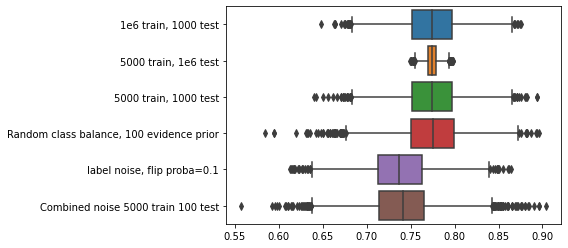

In [124]:
df_LR = pd.DataFrame({'1e6 train, 1000 test': precs1, '5000 train, 1e6 test': precs2, '5000 train, 1000 test': precs3,
                   'Random class balance, 100 evidence prior': precs4_2, 'label noise, flip proba=0.1': precs5, 'Combined noise 5000 train 1000 test':precs_7})
sns.boxplot(data=df_LR, orient='h')


#### 4. Consider now two models with non-deterministic training: XGBoost and a neural net (MLP), what is the distribution of the precision on a single dataset due to non-deterministic training?

In [109]:
def sim_nd_train_prec(train_size, test_size, weights, model_name, n_runs, nd_train = True, flip_y=0, random_imbalance=False, gen_seed=123, tau=0.5, n_jobs=1):
    generator = BlobGenerator(
        train_size=train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
    )
    LA = LAlgorithm(model_name, generator, nd_train=nd_train)
    cms = LA.repeat_nd_train(n_runs, data_seed=gen_seed,
                             tau=tau, n_jobs=n_jobs)
    precs = LA._cms_to_precision(cms)
    return precs

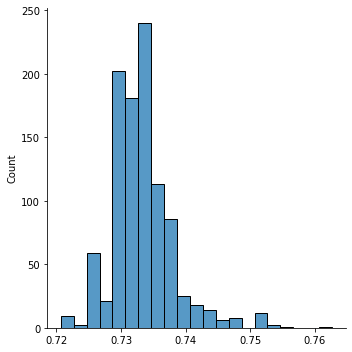

In [104]:
precs_NN = sim_nd_train_prec(
    train_size=5000, 
    test_size=1000, 
    weights=[0.8,0.2], 
    model_name='NN', 
    nd_train=True, 
    n_runs=1000, 
    tau=0.5, 
    n_jobs=-2,
    gen_seed=12)

sns.displot(precs_NN,binwidth = 0.002)

# distribution NN performance given a fixed dataset is quite wide


In [110]:
precs_GB = sim_nd_train_prec(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='XGB',
    nd_train=True,
    n_runs=1000,
    tau=0.5,
    n_jobs=-2,
    gen_seed=12)

precs_LR = sim_nd_train_prec(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='LR',
    nd_train=True,
    n_runs=1000,
    tau=0.5,
    n_jobs=-2,
    gen_seed=12)

<AxesSubplot:>

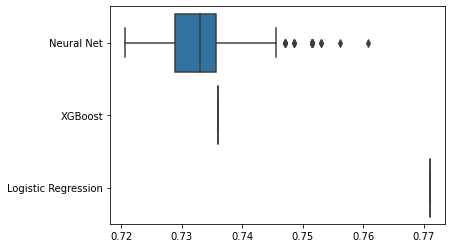

In [123]:
df = pd.DataFrame({'Neural Net': precs_NN, 'XGBoost': precs_GB,
                  'Logistic Regression': precs_LR})
sns.boxplot(data=df,orient='h')

#### 5. Uncertainty for LR, XGB and NN for random train/test draw

In [126]:
precs_NN_clean = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    model_name='NN',
    nd_train=True,
    n_runs=5000
    )

precs_NN_noise = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    random_imbalance=True,
    imbalance_prior_a=80,
    imbalance_prior_b=20,
    nd_train=True,
    model_name='NN',
    n_runs=5000
    )

precs_XGB_clean = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    nd_train=True,
    model_name='XGB',
    n_runs=5000
    )

precs_XGB_noise = sim_precisions(
    train_size=5000,
    test_size=1000,
    weights=[0.8, 0.2],
    random_imbalance=True,
    imbalance_prior_a=80,
    imbalance_prior_b=20,
    nd_train=True,
    model_name='XGB',
    n_runs=5000
    )

In [ ]:
df = pd.DataFrame({'NN clean' : precs_NN_clean, 'NN noisy': precs_NN_noise, 'XGB clean': precs_XGB_clean, 'XGB noisy' : precs_XGB_noise, 'LR clean' : precs3,
 'LR noisy': precs_LR_noise})
sns.boxplot(data=df,orient='h')

#### Investigating the differences in variance for a NN depending on data sample

In [23]:
def sim_var_prec_nd(train_size, test_size, weights, flip_y, random_imbalance, gen_seed, model_name, fix_init, n_runs, n_sets, tau=0.5, parallel=False):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
    )
    LA = LAlgorithm(model_name, generator, fix_init=fix_init)
    stds = LA.sim_prec_std(n_sets, n_runs, parallel=parallel)
    return stds


def sim_iv_prec_nd(train_size, test_size, weights, flip_y, random_imbalance, gen_seed, model_name, fix_init, n_runs, n_sets, qrange=0.95, tau=0.5, parallel=False):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
    )
    LA = LAlgorithm(model_name, generator, fix_init=fix_init)
    iv_lens = LA.sim_prec_iv(n_sets, n_runs, qrange, parallel, n_jobs=15)
    return iv_lens


In [24]:
train_size = 5000
test_size = 1000
weights = [0.8, 0.2]
n_runs = 100
n_sets = 100
flip_y = 0
random_imbalance = False
fix_init = False
model_name = 'NN'
gen_seed = 12

iv_lens = sim_iv_prec_nd(
    train_size,
    test_size,
    weights,
    flip_y,
    random_imbalance,
    gen_seed,
    model_name,
    fix_init,
    n_runs,
    n_sets,
    qrange=0.95,
    tau=0.5,
    parallel=True)


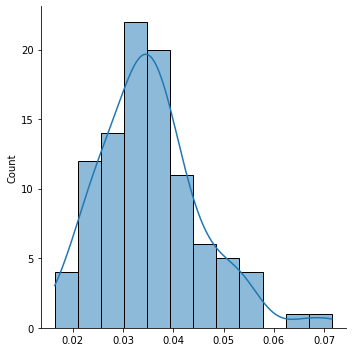

In [25]:
sns.displot(iv_lens, kde=True)


#### To be continued

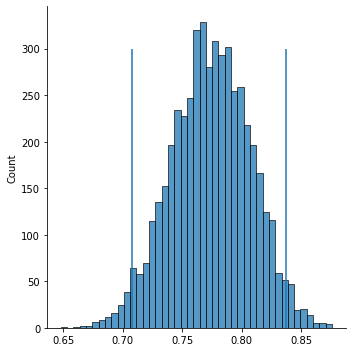

In [47]:
# np.quantile(precs0,0.9)
# sns.displot(precs1)
# plt.vlines([np.quantile(precs1,0.025),np.quantile(precs1,0.975)],ymin=0,ymax=300)


In [62]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator
# train_size = 1000
# test_frac = 1/5
# weights = [0.8,0.2]
# n_sets = 100
# random_imbalance = False
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 10

# def simulate_cms(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,random_state,train_seed=0):
#     data_dict = f.generate_blobs(train_size = train_size,test_size=int(test_frac*train_size),n_sets=n_sets,
#                                 random_state = random_state,flip_y=flip_y,weights = weights,random_imbalance=random_imbalance)
#     return f.holdout_CM(model_name,data_dict,train_seed,fix_init=fix_init)

# cms = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# # precisions
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recalls
# FN = cms[:,1,0]
# recs = TP/(TP+FN)


Here I experiment with different weight splits, to observe the effect on 3 models: Logistic regression, neural network and Gradient Boosting

In [144]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator

# def flatten(t):
#     return [item for sublist in t for item in sublist]

# def simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats):
#     precs_list = []
#     recs_list = []
#     col_model = []
#     col_balance = []

#     for model_name in model_names:
#         for w in weight_splits:
#             weights = [1-w,w]
#             cms = np.vstack(Parallel(n_jobs=-1,verbose = 1)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#                 fix_init,random_state=seed_i) for seed_i in range(repeats)))

#             # precisions
#             TP = cms[:,1,1]
#             FP = cms[:,0,1]
#             precs = TP/(TP+FP)

#             #recalls
#             FN = cms[:,1,0]
#             recs = TP/(TP+FN)
#             precs_list.append(precs.tolist())
#             recs_list.append(recs.tolist())
#             col_model.append(np.repeat(model_name,n_sets*repeats).tolist())
#             col_balance.append(np.repeat(w,n_sets*repeats).tolist())
#     results = {'precision': flatten(precs_list), 'recall':flatten(recs_list),'model':flatten(col_model),'balance':flatten(col_balance)}
#     return results


In [173]:
# model_names = ['LR','NN','GB']
# # weight_splits = [0.1,0.3,0.5]
# train_sizes = [100,200,300]

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True
# # flip_y = 0
# fix_init = True
# repeats = 1000

# for flip_y in [0.05,0.1,0.2]:

#     filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
#     plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

#     results = simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats)

#     pd.DataFrame(results).to_csv(plot_dir + filename +'.csv')


First consider only the noise introduced due to random class balance. First we fix the (mean) balance at 0.3, and set the train size at 1000. Consider a Logistic Regression model

In [61]:
# train_size = 500
# test_frac = 1/5
# weights = [0.7,0.3]
# n_sets = 1
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 1000

# random_imbalance = False
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# random_imbalance = True
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))


In [172]:
# plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = False
# flip_y = 0
# fix_init = True
# repeats = 1000
# filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
# df_0 = pd.read_csv(plot_dir + filename +'.csv')

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True #random imbalance included
# flip_y = 0
# fix_init = True
# repeats = 1000
# filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
# df_1 = pd.read_csv(plot_dir + filename +'.csv')


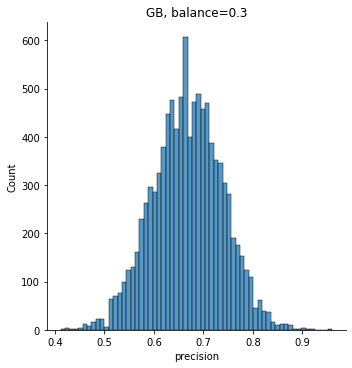

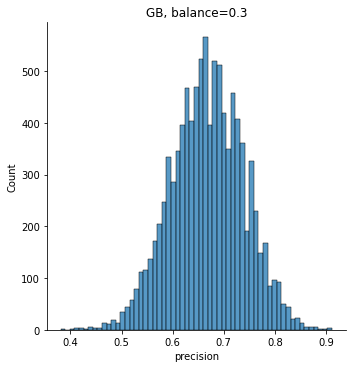

In [171]:
# # df_0 = pd.DataFrame(results)
# # sns.displot(df_0,x = 'precision',hue = 'model',col = 'balance',kde=True)
# # df_0.to_csv('results0.csv')
# # df
# def make_plot(df,model,balance,metric='precision'):
#     df_slice = df[(df['balance']==balance)& (df['model']==model)]
#     sns.displot(data=df_slice,x=metric)
#     plt.title(' '.join([model + ',','balance=' + str(balance)]))
# # sns.displot(data = df_0[(df_0['balance']==0.3)&(df_0['model']=='LR')],x = 'precision')
# # plt.title(' '.join(['LR,','balance=' + str(0.3)]))

# # make_plot(df_0,'LR',0.1,metric='recall')
# make_plot(df_0,'GB',0.3,metric='precision')
# make_plot(df_1,'GB',0.3,metric='precision')
# # make_plot(df_0,'LR',0.5,metric='recall')


In [84]:
# pd.DataFrame(np.array(precs_list).T)
# np.array(precs_list).flatten().shape
# col_model = np.repeat(model_names,repeats*n_sets*len(weight_splits)).shape
# col_balance =
# # cms.shape


(600,)

In [6]:
# import matplotlib.cm as cm

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# H, xedges, yedges= np.histogram2d(precs,recs)


# xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = H.ravel()

# cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
# max_height = np.max(dz)   # get range of colorbars so we can normalize
# min_height = np.min(dz)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap((k-min_height)/max_height) for k in dz]

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color = rgba)

# plt.show()


Retrieving the true precisions and recalls

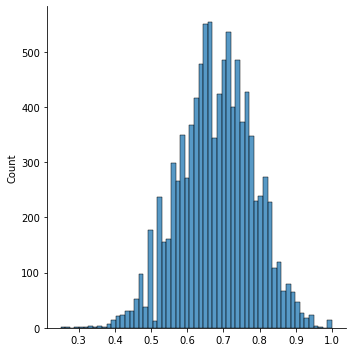

In [19]:
# # precs
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recs
# FN = cms[:,1,0]
# recs = TP/(TP+FN)

# sns.displot(precs)


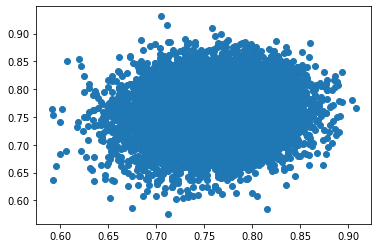

In [8]:
# plt.scatter(precs,recs)


Method by Caelen (2017), multinomial likelihood with Dirichlet priors

In [28]:
# #Given an observed CM, compute the distribution of a performance metric by MC-sampling
# from numpy.random import default_rng

# theta_prior = np.ones(4)
# rng = default_rng(0)
# cm = cms[0]

# def sample_CM(v,theta_prior):
#     theta_post = rng.dirichlet(alpha = v + theta_prior)
#     cm = rng.multinomial(n = v.sum(), pvals = theta_post)
#     return cm.tolist()

# def sample_CM_N(v,theta_prior,MC_N=1000):
#     CL_cms = np.zeros((MC_N,4),dtype = int)
#     for i in range(MC_N):
#         CL_cms[i] = sample_CM(v,theta_prior)
#     return CL_cms

# def prec_from_CMs(cms):
#     TP = cms[:,-1]
#     FP = cms[:,1]
#     return TP/(TP+FP)

# def rec_from_CMs(cms):
#     TP = cms[:,-1]
#     FN = cms[:,-2]
#     return TP/(TP+FN)


In [37]:
# cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
# Cae_precs = []

# for cm in cms[:3]:
#     cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
#     Cae_precs.append(prec_from_CMs(cms_CA))


C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of precision')

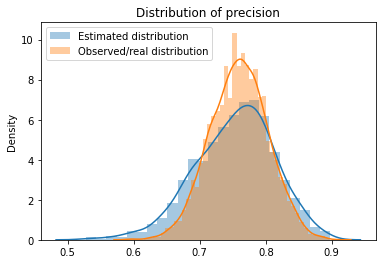

In [47]:
# sns.distplot(Cae_precs[2], label = 'Estimated distribution')
# sns.distplot(precs, label = 'Observed/real distribution')
# plt.legend()
# plt.title('Distribution of precision')

# #TODO: Calculate the coverage and size of confidence intervals created by Caelen's method


In [9]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import confusion_matrix

# def CM_cv(X,y,test_frac,model_name,seed=0,fix_train = False):
#     kf = KFold(n_splits = int(1/test_frac)+1)
#     LA = LAlgorithm(model_name)
#     cms = []
#     for train_index, test_index in kf.split(X):
#         if not fix_train:
#             seed+=1
#         model = LA.init_model(random_state = seed) #initialize model
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         model.fit(X_train,y_train)
#         y_pred = model.predict(X_test)
#         cms.append(confusion_matrix(y_test,y_pred).tolist())
#     return cms


In [10]:
# data_dict = f.generate_blobs(train_size = 1000,test_size=200,n_sets=n_sets,random_state = 1,flip_y=0.1)
# X,y = f.unpack_data_dict(data_dict,stack = True)
# cms_cv = CM_cv(X[0],y[0],test_frac,model_name)
# np.array(cms_cv)


array([[[81, 19],
        [37, 63]],

       [[73, 22],
        [31, 74]],

       [[67, 32],
        [27, 74]],

       [[77, 28],
        [17, 78]],

       [[78, 35],
        [28, 59]],

       [[68, 27],
        [31, 74]]])

In [66]:
# CM_cv(X_train[0],y,test_frac,seed,model_name,fix_train = False)


(1000, 1000, 2)

Firstly, consider the case where we have only a single train-test run. This is equivalent to a holdout estimator. 
To obtain a confidence interval we need to evaluate the variance of this estimator. 

This can be done by:
1.  assuming a binomial distribution on the precision/recall and using a normal approximation for the confidence interval

In [6]:
# # %% To obtain a confidence interval of the expected precision we need to evaluate the variance of the holdout estimator. This can be done by assuming
# #a binomial distribution and using a normal approximation for the confidence interval
# n_pos = out[:,2,:].flatten()

# l = true_precs - 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)
# u = true_precs + 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)

# #fraction of confidence intervals that cover the true population parameter value
# print(np.mean((l<EP_prec) & (EP_prec<u)))

# #We observe that the confidence interval is approximately correct, it covers the true mean in about 94 percent of the cases.

# #Save the widths to compare with the other methods
# holdout_CI_width = u-l


0.9378


2. bootstrapping both train and test

In [56]:
# from numpy.random import default_rng

# def bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False):
#     rng = default_rng(seed)

#     X_train = data_dict['train']['X']
#     y_train = data_dict['train']['y']
#     X_test = data_dict['test']['X']
#     y_test = data_dict['test']['y']

#     X = np.hstack([X_train, X_test])
#     y = np.hstack([y_train, y_test])

#     n_obs = y.shape[1]
#     bs_indices = rng.integers(0,high = n_obs,size = y.shape)

#     X_bs = np.zeros(X.shape)
#     y_bs = np.zeros(y.shape)

#     for i in range(len(y_bs)):
#         X_bs[i] = X[i][bs_indices[i]]
#         y_bs[i] = y[i][bs_indices[i]]

#     train_size = y_train.shape[1]

#     X_train = X_bs[:,:train_size,:]
#     X_test = X_bs[:,train_size:,:]
#     y_train = y_bs[:,:train_size,:]
#     y_test = y_bs[:,train_size:,:]

#     return X_train,X_test,y_train,y_test


# def bootstrap_prec_rec(learn_algo,data_dict,seed=0,fix_init=False):
#     X_train,X_test,y_train,y_test = bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False)

#     if fix_init:
#         train_seed = 0
#     else:
#         train_seed = seed
#     LA = LAlgorithm(learn_algo)

#     precs = []
#     recs = []
#     n_pos = []
#     for i in range(len(y_train)):
#         model = LA.init_model(random_state=train_seed+i)
#         model.fit(X_train[i],y_train[i])
#         y_pred = model.predict(X_test[i])

#         n_pos.append(np.sum(y_pred==1))
#         precs.append(precision_score(y_test[i],y_pred))
#         recs.append(recall_score(y_test[i],y_pred))


IndentationError: expected an indented block (4180208275.py, line 39)

In [52]:


# rng = default_rng(1)
# n_obs = train_size + int(train_size * test_frac)
# data_dict['train']['y'][0]
# data_dict['train']['X']
# bs_indices = rng.integers(0,high = n_obs,size = y.shape)

# X = np.hstack([data_dict['train']['X'], data_dict['test']['X']])
# y = np.hstack([data_dict['train']['y'], data_dict['test']['y']])

# bs_indices

# X_bs = np.zeros(X.shape)
# y_bs = np.zeros(y.shape)

# for i in range(len(y_bs)):
#     X_bs[i] = X[i][bs_indices[i]]
#     y_bs[i] = y[i][bs_indices[i]]


In [55]:
# bs_indices[0]


array([567, 614, 906, ..., 421, 304, 461], dtype=int64)

In [34]:
# data_dict['test']['X'][0].shape
# np.vstack([data_dict['train']['X'][0],data_dict['test']['X'][0]]).shape


(1200, 2)

3. We can use the Bayesian method by Caelen (2017); use a Multinomial likelihood for the confusion matrix and a Dirichlet prior on the probabilities

In [15]:
# cms = Parallel(n_jobs = -1,verbose = 5)(delayed(f.holdout_CM)(model_name,train_size,test_frac,n_sets=n_sets,seed=seed_i) for seed_i in range(repeats))
# cms = np.vstack(cms)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished
